<a href="https://colab.research.google.com/github/bagusgood/Radio_Fingerprint_6AP/blob/main/Localization_V_TSGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries and Prerequisite

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch.nn.functional as F

import scipy.io
import tensorflow as tf
import ipywidgets as widgets
from keras import initializers
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.backend import clear_session
from keras.utils import to_categorical
from IPython.display import display
from keras.optimizers import Adam
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
from numpy.random import seed
from tqdm import tqdm

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from deepkan import RBFKAN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from keras.layers import Dense

## Parameters

In [ ]:
#Data Parameters
num_of_classes = 20
num_of_features = 6
data_shape = (num_of_features,1)

#MLP Parameters
times_to_run = 1 #Number of times to run MLP model
mlp_epochs = 40
valid_split = 0.25

#GAN Parameters
latent_dim = 100
gan_epochs = 1000

#Random Seeds
selection_seed = 150
seed_multiplier = 1000000

lr_mlp = 0.0002
lr_rbfkan = 0.0001

dataset_file = f"drive/MyDrive/dataset{num_of_features}AP.csv"
BASE_FOLDER = f"/content/drive/MyDrive/thesis/new/{num_of_features}AP/V_TSGAN/R10_S10"
os.makedirs(BASE_FOLDER, exist_ok=True)

In [ ]:
cb1 = widgets.Checkbox(description="Generate missing data only")
slider1 = widgets.FloatSlider(value=0.1, min=0.05, max=1, step=0.05)
slider2 = widgets.IntSlider(value=2, min=0, max=1000, step=250)
vb = widgets.VBox(children = [slider2])
def checkbox(button):
    if button['new']:
        vb.children = []
        slider2.value = 250 - int(slider1.value*250)
    else:
        vb.children = [slider2]
        experiment3 = False
cb1.observe(checkbox, names='value')

print("Percentage of Real Data:")
display(slider1)
print("Number of datapoints GAN generates:")
display(vb)
display(cb1)


Percentage of Real Data:


FloatSlider(value=0.1, max=1.0, min=0.05, step=0.05)

Number of datapoints GAN generates:


Checkbox(value=False, description='Generate missing data only')

In [ ]:
fraction_of_data = slider1.value
data_to_gen = slider2.value

In [ ]:
dataset = pd.read_csv(dataset_file)
labels = dataset.Class.values
labels = labels - 1 #Original label values are from 1 to 4
features = dataset.drop(columns='Class').values

In [ ]:
tr_fea, X_test, tr_label, Y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state= selection_seed,
                                                    stratify=labels)

In [ ]:
X_train = []
Z_train = [] #This is the same as X_train, but it's used for training the GAN
Y_train = []

for idx in range(num_of_classes):
    number_filter = np.where(tr_label == idx)
    X_filtered, Y_filtered = tr_fea[number_filter], tr_label[number_filter]

    num_of_data = (int)(fraction_of_data*X_filtered.shape[0])
    RandIndex = np.random.choice(X_filtered.shape[0],
                                 num_of_data,
                                 replace=False)
    Z_train.append(X_filtered[RandIndex])
    X_train.extend(X_filtered[RandIndex])
    Y_train.extend(Y_filtered[RandIndex])

X_train = np.asarray(X_train, dtype=np.float32)
Y_train = np.asarray(Y_train, dtype=np.float32)

X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

Y_train_encoded = to_categorical(Y_train)
Y_test_encoded = to_categorical(Y_test)

In [ ]:
#Data must be standized using standard scaler before using the MLP.
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)

In [ ]:
# Hyperparameters
input_dim = num_of_features
output_dim = num_of_classes
hidden_layers = [64, 128]  # Adjusted hidden layers
num_epochs = mlp_epochs  # Number of epochs
num_iterations = times_to_run  # Number of iterations (i)

# Split data into train, validation, and test sets
features_train, features_val, labels_train, labels_val = train_test_split(X_train_transformed, Y_train, test_size=valid_split, random_state=42)

features_test = X_test_transformed
labels_test = Y_test

# Convert to PyTorch tensors
features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.long)
features_val_tensor = torch.tensor(features_val, dtype=torch.float32)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.long)
features_test_tensor = torch.tensor(features_test, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.long)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(features_train_tensor, labels_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(features_val_tensor, labels_val_tensor), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(features_test_tensor, labels_test_tensor), batch_size=64, shuffle=False)

# Store results
test_accuracies_mlp = []
test_accuracies_rbf = []

# Classification with MLP for Real Data

In [ ]:
# Simpan hasil
test_accuracies_mlp = []
all_test_loss = []
history = []

# Inisialisasi model terbaik
best_model_mlp = None
best_acc = 0

# Training loop
for i in range(times_to_run):
    seed(i * seed_multiplier)
    tf.random.set_seed(i * seed_multiplier)

    model = Sequential()
    model.add(Input(shape=(num_of_features,)))  # Define input shape explicitly
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_of_classes, activation='softmax'))

    model.compile(optimizer=Adam(lr_mlp, 0.5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history_temp = model.fit(X_train_transformed,
                            Y_train_encoded,
                            epochs=mlp_epochs,
                            batch_size=64,
                            validation_split=valid_split,
                            verbose=0)
    history.append(history_temp)

    test_loss, test_acc = model.evaluate(X_test_transformed, Y_test_encoded, verbose=0)

    print(f"#{i} Test acc:", test_acc)
    test_accuracies_mlp.append(test_acc)
    all_test_loss.append(test_loss)

    # Simpan model terbaik
    if test_acc > best_acc:
        best_model_mlp = model
        best_acc = test_acc
    else:
        del model
        clear_session()

print("📊 Rata-rata akurasi:", np.mean(test_accuracies_mlp))
print("🎯 Akurasi terbaik:", best_acc)

#0 Test acc: 0.2857142984867096
📊 Rata-rata akurasi: 0.2857142984867096
🎯 Akurasi terbaik: 0.2857142984867096


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
📊 Macro Average AUC: 0.8476
📊 Micro Average AUC: 0.7493


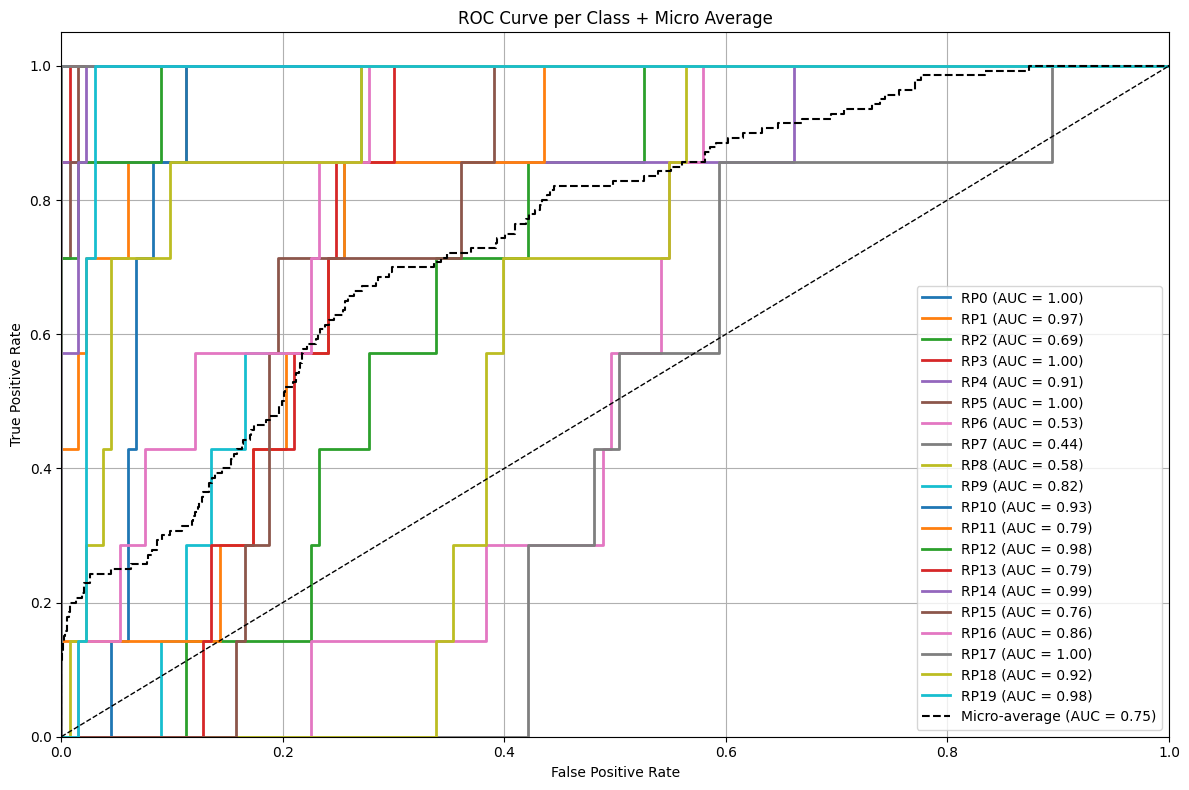

In [ ]:
# Binarisasi label untuk ROC (one-hot)
y_pred_prob = best_model_mlp.predict(X_test_transformed)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(Y_test_encoded, axis=1)
y_test_bin = label_binarize(y_true, classes=range(num_of_classes))  # shape: (n_samples, n_classes)
# Simpan micro-average ROC curve dalam list

# ROC dan AUC per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung macro average AUC
macro_auc_m = np.mean(list(roc_auc.values()))

# Hitung micro average AUC (gabungkan semua prediksi)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
micro_auc_m = auc(fpr["micro"], tpr["micro"])

# 🌈 Plot ROC curve untuk beberapa kelas (maks 20)
plt.figure(figsize=(12, 8))
for i in range(min(20, num_of_classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'RP{i} (AUC = {roc_auc[i]:.2f})')

# Tambahkan micro ROC
plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--',
         label=f'Micro-average (AUC = {micro_auc_m:.2f})')

micro_fpr_list_m = []
micro_tpr_list_m = []
micro_fpr_list_m.append(fpr["micro"])
micro_tpr_list_m.append(tpr["micro"])

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class + Micro Average")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Print summary
print(f"📊 Macro Average AUC: {macro_auc_m:.4f}")
print(f"📊 Micro Average AUC: {micro_auc_m:.4f}")

# Simpan hasil
filename = 'ROC_MLP.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# RBFKAN Real Data

In [ ]:
# Store history untuk akurasi dan loss
train_accuracies_rbfkan = []
val_accuracies_rbfkan = []
train_losses_rbfkan = []
val_losses_rbfkan = []
test_accuracies_rbf = []

best_model_rbfkan = None
best_acc_rbfkan = 0

for i in range(num_iterations):
    print(f"🔁 Iterasi ke-{i+1}")
    torch.manual_seed(i * seed_multiplier)
    np.random.seed(i * seed_multiplier)

    # Inisialisasi model
    model = RBFKAN(
        layers_hidden=[input_dim] + hidden_layers + [output_dim],
        use_base_update=True,
        base_activation=nn.SiLU(),
        spline_weight_init_scale=0.1
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rbfkan)
    criterion = nn.CrossEntropyLoss()

    # Simpan akurasi & loss per epoch (untuk satu iterasi)
    train_acc_epochs = []
    val_acc_epochs = []
    train_loss_epochs = []
    val_loss_epochs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == batch_y).sum().item()
            total_train += batch_y.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_loss_epochs.append(avg_train_loss)
        train_acc_epochs.append(train_accuracy)

        # Validasi
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct_val += (preds == val_y).sum().item()
                total_val += val_y.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_loss_epochs.append(avg_val_loss)
        val_acc_epochs.append(val_accuracy)

    # Simpan per-epoch hasil iterasi ini
    train_accuracies_rbfkan.append(train_acc_epochs)
    val_accuracies_rbfkan.append(val_acc_epochs)
    train_losses_rbfkan.append(train_loss_epochs)
    val_losses_rbfkan.append(val_loss_epochs)

    # Evaluasi akhir di test set
    model.eval()
    with torch.no_grad():
        outputs = model(features_test_tensor)
        preds = torch.argmax(outputs, dim=1)
        test_acc = accuracy_score(labels_test_tensor.numpy(), preds.numpy())
        test_accuracies_rbf.append(test_acc)

    print(f"✅ Val acc (last epoch): {val_accuracy:.4f}, Test acc: {test_acc:.4f}")
    if test_acc > best_acc_rbfkan:
        best_model_rbfkan = model
        best_acc_rbfkan = test_acc
    else:
        del model
        torch.cuda.empty_cache()

# Rata-rata per epoch dari semua iterasi
train_accuracies_rbfkan = np.mean(train_accuracies_rbfkan, axis=0)
val_accuracies_rbfkan = np.mean(val_accuracies_rbfkan, axis=0)
train_losses_rbfkan = np.mean(train_losses_rbfkan, axis=0)
val_losses_rbfkan = np.mean(val_losses_rbfkan, axis=0)

print("📊 Rata-rata akurasi uji RBFKAN:", np.mean(test_accuracies_rbf))
print("🎯 Akurasi terbaik RBFKAN:", best_acc_rbfkan)


🔁 Iterasi ke-1
✅ Val acc (last epoch): 0.1000, Test acc: 0.5143
📊 Rata-rata akurasi uji RBFKAN: 0.5142857142857142
🎯 Akurasi terbaik RBFKAN: 0.5142857142857142


📊 Macro Average AUC (RBFKAN): 0.9220
📊 Micro Average AUC (RBFKAN): 0.8661


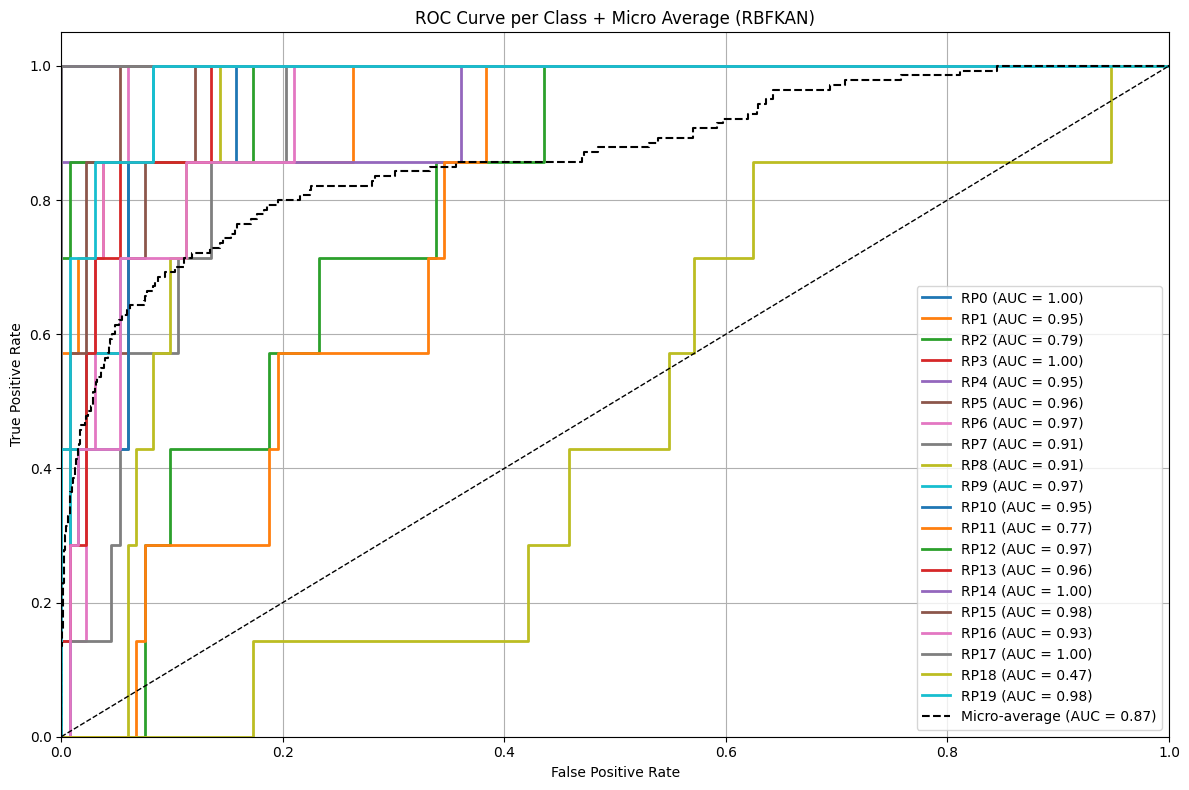

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os

# Pastikan model dalam mode evaluasi
best_model_rbfkan.eval()

# Prediksi probabilitas (softmax)
with torch.no_grad():
    logits = best_model_rbfkan(features_test_tensor)
    y_pred_prob = F.softmax(logits, dim=1).numpy()
    y_true = labels_test_tensor.numpy()

# Binarisasi label untuk ROC (one-hot)
y_test_bin = label_binarize(y_true, classes=range(num_of_classes))  # shape: (n_samples, n_classes)

# ROC dan AUC per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung macro average AUC
macro_auc_r = np.mean(list(roc_auc.values()))

# Hitung micro average AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
micro_auc_r = auc(fpr["micro"], tpr["micro"])

# 🌈 Plot ROC curve
plt.figure(figsize=(12, 8))
for i in range(min(20, num_of_classes)):  # Batasi maksimal 20 kelas
    plt.plot(fpr[i], tpr[i], lw=2, label=f'RP{i} (AUC = {roc_auc[i]:.2f})')

# Tambahkan micro average
plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--',
         label=f'Micro-average (AUC = {micro_auc_r:.2f})')

micro_fpr_list_r = []
micro_tpr_list_r = []
micro_fpr_list_r.append(fpr["micro"])
micro_tpr_list_r.append(tpr["micro"])

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class + Micro Average (RBFKAN)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Print summary
print(f"📊 Macro Average AUC (RBFKAN): {macro_auc_r:.4f}")
print(f"📊 Micro Average AUC (RBFKAN): {micro_auc_r:.4f}")

# Simpan hasil
filename = 'ROC_RBF.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

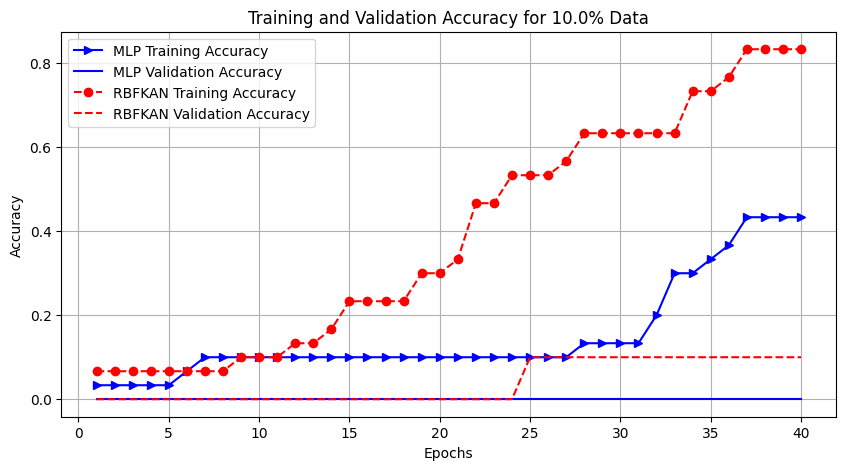

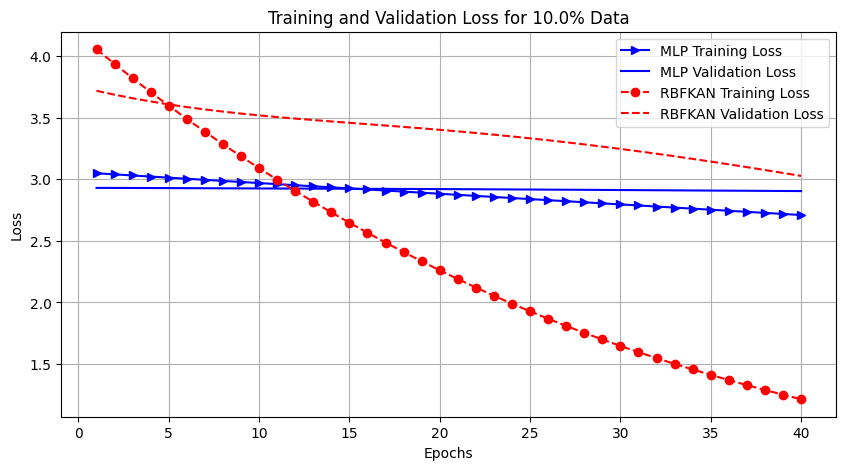

In [ ]:
# MLP metrics
trainacc = []
trainloss = []
valacc = []
valloss = []

for i in range(len(history)):
    trainacc.append(history[i].history['accuracy'])
    trainloss.append(history[i].history['loss'])
    valacc.append(history[i].history['val_accuracy'])
    valloss.append(history[i].history['val_loss'])

acc = np.mean(trainacc, axis=0)
val_acc = np.mean(valacc, axis=0)
loss = np.mean(trainloss, axis=0)
val_loss = np.mean(valloss, axis=0)
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'b>-', label='MLP Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='MLP Validation Accuracy')
plt.plot(epochs, train_accuracies_rbfkan, 'ro--', label='RBFKAN Training Accuracy')
plt.plot(epochs, val_accuracies_rbfkan, 'r--', label='RBFKAN Validation Accuracy')
plt.title('Training and Validation Accuracy for {}% Data'.format(fraction_of_data*100))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

filename = 'Pre-Accuracy.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b>-', label='MLP Training Loss')
plt.plot(epochs, val_loss, 'b-', label='MLP Validation Loss')
plt.plot(epochs, train_losses_rbfkan, 'ro--', label='RBFKAN Training Loss')
plt.plot(epochs, val_losses_rbfkan, 'r--', label='RBFKAN Validation Loss')
plt.title('Training and Validation Loss for {}% Data'.format(fraction_of_data*100))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

filename = 'Pre-Loss.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# Generating Synthetic Data


In [ ]:
def build_generator():
    noise = Input(shape=(latent_dim,))
    x = Dense(256)(noise)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(np.prod(data_shape), activation='tanh')(x)
    gendata = Reshape(data_shape)(x)

    model = Model(noise, gendata)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    return model

def build_discriminator():
    data = Input(shape=data_shape)
    x = Flatten()(data)
    x = Dense(512)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    validity = Dense(1, activation='sigmoid')(x)

    model = Model(data, validity)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    return model

In [ ]:
dis_loss = []
gen_loss = []
all_loss = []

# Optimizer
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

def train_tsgan(epochs, features, batch_size=64):
    valid = np.ones((batch_size, 1)) * 0.9  # Real label = 0.9, bukan 1.0
    fake = np.zeros((batch_size, 1)) * 0.1  # Fake label = 0.1, bukan 0.0

    for epoch in range(epochs):
        idx = np.random.randint(0, features.shape[0], batch_size)
        real_data = features[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train Discriminator
        with tf.GradientTape() as d_tape:
            generated_data = generator(noise, training=True)
            real_output = discriminator(real_data, training=True)
            fake_output = discriminator(generated_data, training=True)

            d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(valid, real_output))
            d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake, fake_output))
            d_loss = d_loss_real + d_loss_fake

        d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        with tf.GradientTape() as g_tape:
            generated_data = generator(noise, training=True)
            fake_output = discriminator(generated_data, training=True)
            g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(valid, fake_output))

        g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

        # Save loss
        dis_loss.append(d_loss.numpy())
        gen_loss.append(g_loss.numpy())
        all_loss.append(np.absolute(d_loss.numpy() - g_loss.numpy()))

        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}")

In [ ]:
# Pastikan tensor list global
dis_loss = []
gen_loss = []
all_loss = []

# Optimizer (gunakan global scope jika perlu)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

@tf.function
def train_step_tsgan(features, batch_size):
    # Label real dan fake
    valid = tf.ones((batch_size, 1), dtype=tf.float32) * 0.9
    fake = tf.zeros((batch_size, 1), dtype=tf.float32) * 0.1

    # Ambil real data dari fitur
    idx = tf.random.uniform((batch_size,), 0, tf.shape(features)[0], dtype=tf.int32)
    real_data = tf.gather(features, idx)

    # ---------------------
    # Train Discriminator
    # ---------------------
    noise = tf.random.normal((batch_size, latent_dim))
    with tf.GradientTape() as d_tape:
        generated_data = generator(noise, training=True)
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)

        d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(valid, real_output))
        d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake, fake_output))
        d_loss = d_loss_real + d_loss_fake

    d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    # ---------------------
    # Train Generator
    # ---------------------
    noise = tf.random.normal((batch_size, latent_dim))
    with tf.GradientTape() as g_tape:
        generated_data = generator(noise, training=True)
        fake_output = discriminator(generated_data, training=True)
        g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(valid, fake_output))

    g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

    return d_loss, g_loss

def train_tsgan(epochs, features, batch_size=64):
    # Pastikan tensor float32 untuk berjalan di GPU
    features = tf.convert_to_tensor(features, dtype=tf.float32)

    for epoch in range(epochs):
        d_loss, g_loss = train_step_tsgan(features, batch_size)

        # Simpan hasil loss
        dis_loss.append(d_loss.numpy())
        gen_loss.append(g_loss.numpy())
        all_loss.append(np.abs(d_loss.numpy() - g_loss.numpy()))

        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, D Loss: {d_loss.numpy():.4f}, G Loss: {g_loss.numpy():.4f}")

In [ ]:
# Training for each class
gen_data = []

for i in tqdm(range(num_of_classes)):
    # Build models
    discriminator = build_discriminator()
    generator = build_generator()

    # Create new optimizers for each model
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

    # Transform data
    minimaxscaler = MinMaxScaler((-1, 1))
    Z_train_transformed = minimaxscaler.fit_transform(Z_train[i])
    Z_train_transformed = np.expand_dims(Z_train_transformed, axis=2)

    # Train GAN
    train_tsgan(
        epochs=gan_epochs,
        features=Z_train_transformed,
        batch_size=64
    )

    # Generate new data
    noise = np.random.normal(0, 1, (data_to_gen, latent_dim))
    gen_data_temp = generator.predict(noise)
    gen_data_temp = np.asarray(gen_data_temp, dtype=np.float32)
    gen_data_temp = np.squeeze(gen_data_temp)
    gen_data_temp = minimaxscaler.inverse_transform(gen_data_temp)

    gen_data.append(gen_data_temp)

    # Clear session
    clear_session()
    del discriminator
    del generator

gen_data = np.asarray(gen_data, dtype=np.float32)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, D Loss: 1.4063, G Loss: 0.7275
Epoch: 10, D Loss: 1.3114, G Loss: 0.7263
Epoch: 20, D Loss: 1.2944, G Loss: 0.7099
Epoch: 30, D Loss: 1.3165, G Loss: 0.7024
Epoch: 40, D Loss: 1.3259, G Loss: 0.6952
Epoch: 50, D Loss: 1.3349, G Loss: 0.7188
Epoch: 60, D Loss: 1.3258, G Loss: 0.7352
Epoch: 70, D Loss: 1.3400, G Loss: 0.7451
Epoch: 80, D Loss: 1.3316, G Loss: 0.7389
Epoch: 90, D Loss: 1.3414, G Loss: 0.7711
Epoch: 100, D Loss: 1.3232, G Loss: 0.7387
Epoch: 110, D Loss: 1.3226, G Loss: 0.7766
Epoch: 120, D Loss: 1.3346, G Loss: 0.7604
Epoch: 130, D Loss: 1.3397, G Loss: 0.7754
Epoch: 140, D Loss: 1.3482, G Loss: 0.7843
Epoch: 150, D Loss: 1.3377, G Loss: 0.7753
Epoch: 160, D Loss: 1.3513, G Loss: 0.7638
Epoch: 170, D Loss: 1.3361, G Loss: 0.7814
Epoch: 180, D Loss: 1.3502, G Loss: 0.7749
Epoch: 190, D Loss: 1.3201, G Loss: 0.7756
Epoch: 200, D Loss: 1.3344, G Loss: 0.7955
Epoch: 210, D Loss: 1.3399, G Loss: 0.8011
Epoch: 220, D Loss: 1.3311, G Loss: 0.7823
Epoch: 230, D Loss: 1.

  5%|▌         | 1/20 [00:11<03:41, 11.65s/it]

Epoch: 0, D Loss: 5.1584, G Loss: 0.7654
Epoch: 10, D Loss: 1.4586, G Loss: 0.9988
Epoch: 20, D Loss: 0.8048, G Loss: 1.3924
Epoch: 30, D Loss: 0.6109, G Loss: 1.7446
Epoch: 40, D Loss: 0.5008, G Loss: 2.0589
Epoch: 50, D Loss: 0.4470, G Loss: 2.3325
Epoch: 60, D Loss: 0.4284, G Loss: 2.6033
Epoch: 70, D Loss: 0.4263, G Loss: 2.7306
Epoch: 80, D Loss: 0.4068, G Loss: 2.8271
Epoch: 90, D Loss: 0.3985, G Loss: 2.9754
Epoch: 100, D Loss: 0.3952, G Loss: 3.2202
Epoch: 110, D Loss: 0.4112, G Loss: 3.3165
Epoch: 120, D Loss: 0.4212, G Loss: 3.2928
Epoch: 130, D Loss: 0.4478, G Loss: 3.4232
Epoch: 140, D Loss: 0.4295, G Loss: 3.6663
Epoch: 150, D Loss: 0.4005, G Loss: 3.4859
Epoch: 160, D Loss: 0.4606, G Loss: 3.8357
Epoch: 170, D Loss: 0.6055, G Loss: 3.8058
Epoch: 180, D Loss: 0.4973, G Loss: 4.0330
Epoch: 190, D Loss: 0.5234, G Loss: 3.7435
Epoch: 200, D Loss: 0.5901, G Loss: 3.4633
Epoch: 210, D Loss: 0.8162, G Loss: 3.3870
Epoch: 220, D Loss: 0.7504, G Loss: 3.2601
Epoch: 230, D Loss: 0.

 10%|█         | 2/20 [00:19<02:44,  9.14s/it]

Epoch: 0, D Loss: 7.5061, G Loss: 0.9096
Epoch: 10, D Loss: 2.4489, G Loss: 1.4676
Epoch: 20, D Loss: 0.9121, G Loss: 1.8538
Epoch: 30, D Loss: 0.8592, G Loss: 1.8331
Epoch: 40, D Loss: 0.8570, G Loss: 2.1645
Epoch: 50, D Loss: 0.8856, G Loss: 2.5618
Epoch: 60, D Loss: 0.7979, G Loss: 2.6275
Epoch: 70, D Loss: 0.8537, G Loss: 2.9196
Epoch: 80, D Loss: 0.8333, G Loss: 3.0758
Epoch: 90, D Loss: 0.8043, G Loss: 2.9120
Epoch: 100, D Loss: 0.8985, G Loss: 3.2422
Epoch: 110, D Loss: 0.9017, G Loss: 2.8098
Epoch: 120, D Loss: 0.8557, G Loss: 2.6925
Epoch: 130, D Loss: 0.8568, G Loss: 2.7027
Epoch: 140, D Loss: 0.8334, G Loss: 2.9261
Epoch: 150, D Loss: 0.8300, G Loss: 2.8304
Epoch: 160, D Loss: 0.8230, G Loss: 2.8108
Epoch: 170, D Loss: 0.8913, G Loss: 2.4748
Epoch: 180, D Loss: 0.9829, G Loss: 2.2221
Epoch: 190, D Loss: 0.9773, G Loss: 2.7567
Epoch: 200, D Loss: 0.9693, G Loss: 2.4565
Epoch: 210, D Loss: 1.0113, G Loss: 2.3923
Epoch: 220, D Loss: 1.0423, G Loss: 2.2715
Epoch: 230, D Loss: 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 15%|█▌        | 3/20 [00:26<02:22,  8.39s/it]

Epoch: 0, D Loss: 9.2062, G Loss: 0.9122
Epoch: 10, D Loss: 3.4338, G Loss: 1.7263
Epoch: 20, D Loss: 1.1429, G Loss: 1.9629
Epoch: 30, D Loss: 0.6512, G Loss: 2.1953
Epoch: 40, D Loss: 0.5265, G Loss: 2.7469
Epoch: 50, D Loss: 0.4580, G Loss: 3.0827
Epoch: 60, D Loss: 0.4229, G Loss: 3.2388
Epoch: 70, D Loss: 0.7059, G Loss: 3.1872
Epoch: 80, D Loss: 0.7750, G Loss: 2.9801
Epoch: 90, D Loss: 0.7809, G Loss: 2.9330
Epoch: 100, D Loss: 0.8949, G Loss: 3.0586
Epoch: 110, D Loss: 0.8676, G Loss: 2.5385
Epoch: 120, D Loss: 0.8515, G Loss: 2.5110
Epoch: 130, D Loss: 0.8654, G Loss: 2.7203
Epoch: 140, D Loss: 0.8789, G Loss: 2.8157
Epoch: 150, D Loss: 0.8244, G Loss: 2.8856
Epoch: 160, D Loss: 0.7920, G Loss: 2.5371
Epoch: 170, D Loss: 0.8707, G Loss: 2.6628
Epoch: 180, D Loss: 1.0030, G Loss: 2.1776
Epoch: 190, D Loss: 0.9706, G Loss: 2.6197
Epoch: 200, D Loss: 0.8900, G Loss: 2.2936
Epoch: 210, D Loss: 1.0597, G Loss: 2.3072
Epoch: 220, D Loss: 1.0285, G Loss: 2.2172
Epoch: 230, D Loss: 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 20%|██        | 4/20 [00:33<02:07,  7.97s/it]

Epoch: 0, D Loss: 8.2722, G Loss: 0.8527
Epoch: 10, D Loss: 2.8250, G Loss: 1.0661
Epoch: 20, D Loss: 1.0101, G Loss: 1.4673
Epoch: 30, D Loss: 0.5576, G Loss: 1.9439
Epoch: 40, D Loss: 0.4783, G Loss: 2.3825
Epoch: 50, D Loss: 0.4204, G Loss: 2.5686
Epoch: 60, D Loss: 0.4675, G Loss: 2.8003
Epoch: 70, D Loss: 0.4857, G Loss: 2.7188
Epoch: 80, D Loss: 0.4631, G Loss: 2.9873
Epoch: 90, D Loss: 0.4401, G Loss: 3.1026
Epoch: 100, D Loss: 0.5011, G Loss: 2.9131
Epoch: 110, D Loss: 0.5467, G Loss: 2.8647
Epoch: 120, D Loss: 0.5572, G Loss: 2.6088
Epoch: 130, D Loss: 0.5939, G Loss: 2.5309
Epoch: 140, D Loss: 0.5660, G Loss: 2.5705
Epoch: 150, D Loss: 0.6121, G Loss: 2.7002
Epoch: 160, D Loss: 0.6820, G Loss: 2.9093
Epoch: 170, D Loss: 0.7895, G Loss: 2.3979
Epoch: 180, D Loss: 0.9026, G Loss: 2.4252
Epoch: 190, D Loss: 0.8719, G Loss: 2.7222
Epoch: 200, D Loss: 0.8519, G Loss: 2.3977
Epoch: 210, D Loss: 0.9991, G Loss: 1.6842
Epoch: 220, D Loss: 1.2171, G Loss: 1.1109
Epoch: 230, D Loss: 1.

 25%|██▌       | 5/20 [00:41<01:56,  7.76s/it]

Epoch: 0, D Loss: 8.0563, G Loss: 0.8894
Epoch: 10, D Loss: 2.0731, G Loss: 1.3660
Epoch: 20, D Loss: 0.5614, G Loss: 1.9613
Epoch: 30, D Loss: 0.4561, G Loss: 2.1969
Epoch: 40, D Loss: 0.3976, G Loss: 2.5872
Epoch: 50, D Loss: 0.4089, G Loss: 2.6722
Epoch: 60, D Loss: 0.3794, G Loss: 2.8691
Epoch: 70, D Loss: 0.3664, G Loss: 3.0371
Epoch: 80, D Loss: 0.3573, G Loss: 3.1489
Epoch: 90, D Loss: 0.3585, G Loss: 3.2438
Epoch: 100, D Loss: 0.3576, G Loss: 3.3742
Epoch: 110, D Loss: 0.3609, G Loss: 3.4896
Epoch: 120, D Loss: 0.3770, G Loss: 3.7529
Epoch: 130, D Loss: 0.3886, G Loss: 3.7022
Epoch: 140, D Loss: 0.3689, G Loss: 3.7264
Epoch: 150, D Loss: 0.4311, G Loss: 3.6350
Epoch: 160, D Loss: 0.4620, G Loss: 3.6887
Epoch: 170, D Loss: 0.4112, G Loss: 3.7523
Epoch: 180, D Loss: 0.4418, G Loss: 3.6494
Epoch: 190, D Loss: 0.4987, G Loss: 3.8100
Epoch: 200, D Loss: 0.5926, G Loss: 3.8218
Epoch: 210, D Loss: 0.5847, G Loss: 3.5731
Epoch: 220, D Loss: 0.5813, G Loss: 3.3332
Epoch: 230, D Loss: 0.

 30%|███       | 6/20 [00:48<01:46,  7.58s/it]

Epoch: 0, D Loss: 6.3448, G Loss: 0.8329
Epoch: 10, D Loss: 1.6303, G Loss: 1.0199
Epoch: 20, D Loss: 0.6203, G Loss: 1.7021
Epoch: 30, D Loss: 0.4613, G Loss: 2.1142
Epoch: 40, D Loss: 0.4097, G Loss: 2.5703
Epoch: 50, D Loss: 0.4007, G Loss: 2.5470
Epoch: 60, D Loss: 0.3962, G Loss: 3.1437
Epoch: 70, D Loss: 0.4403, G Loss: 3.1422
Epoch: 80, D Loss: 0.3984, G Loss: 3.2381
Epoch: 90, D Loss: 0.3933, G Loss: 3.3231
Epoch: 100, D Loss: 0.3940, G Loss: 3.5321
Epoch: 110, D Loss: 0.4034, G Loss: 3.6228
Epoch: 120, D Loss: 0.4205, G Loss: 3.9139
Epoch: 130, D Loss: 0.4821, G Loss: 3.5662
Epoch: 140, D Loss: 0.4721, G Loss: 3.3270
Epoch: 150, D Loss: 0.4863, G Loss: 3.8708
Epoch: 160, D Loss: 0.5616, G Loss: 4.0056
Epoch: 170, D Loss: 0.5245, G Loss: 3.6810
Epoch: 180, D Loss: 0.6857, G Loss: 3.6020
Epoch: 190, D Loss: 0.6854, G Loss: 3.4504
Epoch: 200, D Loss: 0.7520, G Loss: 3.5791
Epoch: 210, D Loss: 0.7165, G Loss: 3.0444
Epoch: 220, D Loss: 0.7951, G Loss: 3.0834
Epoch: 230, D Loss: 0.

 35%|███▌      | 7/20 [00:55<01:37,  7.53s/it]

Epoch: 0, D Loss: 7.9754, G Loss: 0.9175
Epoch: 10, D Loss: 2.6222, G Loss: 1.5679
Epoch: 20, D Loss: 0.7815, G Loss: 1.8218
Epoch: 30, D Loss: 0.4366, G Loss: 2.4711
Epoch: 40, D Loss: 0.5541, G Loss: 2.7387
Epoch: 50, D Loss: 0.6787, G Loss: 2.6451
Epoch: 60, D Loss: 0.6406, G Loss: 2.7746
Epoch: 70, D Loss: 0.6936, G Loss: 2.8412
Epoch: 80, D Loss: 0.6978, G Loss: 3.0682
Epoch: 90, D Loss: 0.6379, G Loss: 2.9563
Epoch: 100, D Loss: 0.7690, G Loss: 3.1637
Epoch: 110, D Loss: 0.7046, G Loss: 3.3225
Epoch: 120, D Loss: 0.7626, G Loss: 3.1814
Epoch: 130, D Loss: 0.7297, G Loss: 3.3475
Epoch: 140, D Loss: 0.7319, G Loss: 3.4423
Epoch: 150, D Loss: 0.7261, G Loss: 3.1930
Epoch: 160, D Loss: 0.7019, G Loss: 2.9940
Epoch: 170, D Loss: 0.7059, G Loss: 2.7855
Epoch: 180, D Loss: 0.8908, G Loss: 2.1090
Epoch: 190, D Loss: 1.2421, G Loss: 1.1557
Epoch: 200, D Loss: 1.2896, G Loss: 0.8064
Epoch: 210, D Loss: 1.2803, G Loss: 0.8627
Epoch: 220, D Loss: 1.3418, G Loss: 0.8647
Epoch: 230, D Loss: 1.

 40%|████      | 8/20 [01:03<01:29,  7.49s/it]

Epoch: 0, D Loss: 5.1394, G Loss: 0.7832
Epoch: 10, D Loss: 1.3618, G Loss: 1.1491
Epoch: 20, D Loss: 0.7141, G Loss: 1.6427
Epoch: 30, D Loss: 0.5583, G Loss: 1.9296
Epoch: 40, D Loss: 0.5118, G Loss: 2.2098
Epoch: 50, D Loss: 0.4940, G Loss: 2.4510
Epoch: 60, D Loss: 0.4486, G Loss: 2.6009
Epoch: 70, D Loss: 0.5016, G Loss: 2.6537
Epoch: 80, D Loss: 0.4704, G Loss: 2.8211
Epoch: 90, D Loss: 0.5027, G Loss: 3.0186
Epoch: 100, D Loss: 0.4992, G Loss: 3.0743
Epoch: 110, D Loss: 0.5737, G Loss: 3.1140
Epoch: 120, D Loss: 0.5682, G Loss: 3.0617
Epoch: 130, D Loss: 0.6954, G Loss: 2.7094
Epoch: 140, D Loss: 0.7238, G Loss: 2.5596
Epoch: 150, D Loss: 0.8620, G Loss: 2.5634
Epoch: 160, D Loss: 0.9539, G Loss: 2.1252
Epoch: 170, D Loss: 1.0004, G Loss: 1.9063
Epoch: 180, D Loss: 0.8888, G Loss: 1.7865
Epoch: 190, D Loss: 0.9419, G Loss: 1.7960
Epoch: 200, D Loss: 0.9957, G Loss: 2.0602
Epoch: 210, D Loss: 0.9479, G Loss: 1.8502
Epoch: 220, D Loss: 0.9683, G Loss: 1.9133
Epoch: 230, D Loss: 0.

 45%|████▌     | 9/20 [01:10<01:21,  7.43s/it]

Epoch: 0, D Loss: 10.3423, G Loss: 0.9852
Epoch: 10, D Loss: 3.6202, G Loss: 1.0555
Epoch: 20, D Loss: 0.9589, G Loss: 1.3661
Epoch: 30, D Loss: 0.5941, G Loss: 1.7711
Epoch: 40, D Loss: 0.5021, G Loss: 2.1372
Epoch: 50, D Loss: 0.4567, G Loss: 2.3558
Epoch: 60, D Loss: 0.4172, G Loss: 2.5795
Epoch: 70, D Loss: 0.4044, G Loss: 2.9011
Epoch: 80, D Loss: 0.5250, G Loss: 3.0650
Epoch: 90, D Loss: 0.4637, G Loss: 2.9857
Epoch: 100, D Loss: 0.4974, G Loss: 3.0720
Epoch: 110, D Loss: 0.6421, G Loss: 2.6503
Epoch: 120, D Loss: 0.8556, G Loss: 2.4133
Epoch: 130, D Loss: 0.5984, G Loss: 2.3072
Epoch: 140, D Loss: 0.6746, G Loss: 2.4522
Epoch: 150, D Loss: 0.6287, G Loss: 2.4400
Epoch: 160, D Loss: 0.5225, G Loss: 2.5938
Epoch: 170, D Loss: 0.5541, G Loss: 2.6188
Epoch: 180, D Loss: 0.6105, G Loss: 2.6640
Epoch: 190, D Loss: 0.7293, G Loss: 2.7259
Epoch: 200, D Loss: 0.6342, G Loss: 2.8719
Epoch: 210, D Loss: 0.7144, G Loss: 2.9205
Epoch: 220, D Loss: 0.6967, G Loss: 2.7119
Epoch: 230, D Loss: 0

 50%|█████     | 10/20 [01:18<01:14,  7.42s/it]

Epoch: 0, D Loss: 6.7615, G Loss: 0.8043
Epoch: 10, D Loss: 1.9954, G Loss: 0.7893
Epoch: 20, D Loss: 0.7928, G Loss: 1.3246
Epoch: 30, D Loss: 0.5608, G Loss: 1.7773
Epoch: 40, D Loss: 0.4769, G Loss: 2.0814
Epoch: 50, D Loss: 0.4781, G Loss: 2.3214
Epoch: 60, D Loss: 0.4561, G Loss: 2.5615
Epoch: 70, D Loss: 0.4529, G Loss: 2.7755
Epoch: 80, D Loss: 0.4631, G Loss: 2.7726
Epoch: 90, D Loss: 0.4482, G Loss: 2.7843
Epoch: 100, D Loss: 0.4861, G Loss: 2.7098
Epoch: 110, D Loss: 0.4566, G Loss: 2.7395
Epoch: 120, D Loss: 0.4706, G Loss: 2.9082
Epoch: 130, D Loss: 0.4451, G Loss: 2.9176
Epoch: 140, D Loss: 0.5083, G Loss: 3.0995
Epoch: 150, D Loss: 0.4346, G Loss: 3.0467
Epoch: 160, D Loss: 0.5214, G Loss: 3.0762
Epoch: 170, D Loss: 0.4534, G Loss: 3.1167
Epoch: 180, D Loss: 0.6121, G Loss: 3.2854
Epoch: 190, D Loss: 0.6066, G Loss: 3.2458
Epoch: 200, D Loss: 0.6387, G Loss: 3.2979
Epoch: 210, D Loss: 0.7038, G Loss: 3.2869
Epoch: 220, D Loss: 0.7110, G Loss: 2.9950
Epoch: 230, D Loss: 0.

 55%|█████▌    | 11/20 [01:25<01:06,  7.43s/it]

Epoch: 0, D Loss: 6.8074, G Loss: 0.8708
Epoch: 10, D Loss: 1.5448, G Loss: 1.5884
Epoch: 20, D Loss: 0.5657, G Loss: 2.0837
Epoch: 30, D Loss: 0.4295, G Loss: 2.7665
Epoch: 40, D Loss: 0.3870, G Loss: 3.0059
Epoch: 50, D Loss: 0.3652, G Loss: 3.2472
Epoch: 60, D Loss: 0.3580, G Loss: 3.4085
Epoch: 70, D Loss: 0.3503, G Loss: 3.6944
Epoch: 80, D Loss: 0.3690, G Loss: 3.6383
Epoch: 90, D Loss: 0.3882, G Loss: 3.7244
Epoch: 100, D Loss: 0.3905, G Loss: 3.6852
Epoch: 110, D Loss: 0.3767, G Loss: 3.8225
Epoch: 120, D Loss: 0.3839, G Loss: 3.9335
Epoch: 130, D Loss: 0.4265, G Loss: 4.0927
Epoch: 140, D Loss: 0.4417, G Loss: 4.1837
Epoch: 150, D Loss: 0.4459, G Loss: 4.0632
Epoch: 160, D Loss: 0.5198, G Loss: 4.1305
Epoch: 170, D Loss: 0.4783, G Loss: 4.0295
Epoch: 180, D Loss: 0.4567, G Loss: 4.0030
Epoch: 190, D Loss: 0.5918, G Loss: 3.8039
Epoch: 200, D Loss: 0.5247, G Loss: 3.9437
Epoch: 210, D Loss: 0.6062, G Loss: 4.1007
Epoch: 220, D Loss: 0.6096, G Loss: 3.9604
Epoch: 230, D Loss: 0.

 60%|██████    | 12/20 [01:32<00:59,  7.43s/it]

Epoch: 0, D Loss: 8.6252, G Loss: 0.8947
Epoch: 10, D Loss: 2.7645, G Loss: 1.4484
Epoch: 20, D Loss: 0.7424, G Loss: 1.8249
Epoch: 30, D Loss: 0.4580, G Loss: 2.4409
Epoch: 40, D Loss: 0.4144, G Loss: 2.9221
Epoch: 50, D Loss: 0.3853, G Loss: 3.2695
Epoch: 60, D Loss: 0.3619, G Loss: 3.3794
Epoch: 70, D Loss: 0.3655, G Loss: 3.4798
Epoch: 80, D Loss: 0.4210, G Loss: 3.3168
Epoch: 90, D Loss: 0.4251, G Loss: 3.4222
Epoch: 100, D Loss: 0.4062, G Loss: 3.2881
Epoch: 110, D Loss: 0.3851, G Loss: 3.2112
Epoch: 120, D Loss: 0.3718, G Loss: 3.2302
Epoch: 130, D Loss: 0.3720, G Loss: 3.3794
Epoch: 140, D Loss: 0.3574, G Loss: 3.4858
Epoch: 150, D Loss: 0.3522, G Loss: 3.6029
Epoch: 160, D Loss: 0.3467, G Loss: 3.7216
Epoch: 170, D Loss: 0.3452, G Loss: 3.8276
Epoch: 180, D Loss: 0.3421, G Loss: 3.8696
Epoch: 190, D Loss: 0.3388, G Loss: 4.0061
Epoch: 200, D Loss: 0.3390, G Loss: 4.0806
Epoch: 210, D Loss: 0.5254, G Loss: 2.9344
Epoch: 220, D Loss: 0.3994, G Loss: 2.8684
Epoch: 230, D Loss: 0.

 65%|██████▌   | 13/20 [01:40<00:52,  7.45s/it]

Epoch: 0, D Loss: 5.0063, G Loss: 0.7606
Epoch: 10, D Loss: 1.1986, G Loss: 0.9357
Epoch: 20, D Loss: 0.6283, G Loss: 1.6751
Epoch: 30, D Loss: 0.5068, G Loss: 1.9900
Epoch: 40, D Loss: 0.4772, G Loss: 2.3617
Epoch: 50, D Loss: 0.5000, G Loss: 2.5998
Epoch: 60, D Loss: 0.6810, G Loss: 2.5168
Epoch: 70, D Loss: 0.8918, G Loss: 2.0248
Epoch: 80, D Loss: 1.0594, G Loss: 2.0323
Epoch: 90, D Loss: 1.1729, G Loss: 1.5760
Epoch: 100, D Loss: 1.2492, G Loss: 1.3813
Epoch: 110, D Loss: 1.2647, G Loss: 1.5204
Epoch: 120, D Loss: 1.2291, G Loss: 1.1231
Epoch: 130, D Loss: 1.2250, G Loss: 1.4114
Epoch: 140, D Loss: 1.2578, G Loss: 1.1798
Epoch: 150, D Loss: 1.3097, G Loss: 1.1656
Epoch: 160, D Loss: 1.2941, G Loss: 0.9356
Epoch: 170, D Loss: 1.3556, G Loss: 0.9418
Epoch: 180, D Loss: 1.3190, G Loss: 0.8889
Epoch: 190, D Loss: 1.3481, G Loss: 1.1204
Epoch: 200, D Loss: 1.3336, G Loss: 0.8336
Epoch: 210, D Loss: 1.3107, G Loss: 0.8589
Epoch: 220, D Loss: 1.3651, G Loss: 1.0101
Epoch: 230, D Loss: 1.

 70%|███████   | 14/20 [01:47<00:44,  7.41s/it]

Epoch: 0, D Loss: 8.0672, G Loss: 0.9105
Epoch: 10, D Loss: 1.6503, G Loss: 1.0632
Epoch: 20, D Loss: 0.4999, G Loss: 1.9568
Epoch: 30, D Loss: 0.4029, G Loss: 2.5306
Epoch: 40, D Loss: 0.3932, G Loss: 2.8720
Epoch: 50, D Loss: 0.3777, G Loss: 3.1430
Epoch: 60, D Loss: 0.3563, G Loss: 3.3348
Epoch: 70, D Loss: 0.3536, G Loss: 3.4279
Epoch: 80, D Loss: 0.4171, G Loss: 3.6932
Epoch: 90, D Loss: 0.4334, G Loss: 3.6730
Epoch: 100, D Loss: 0.5068, G Loss: 2.7975
Epoch: 110, D Loss: 0.4557, G Loss: 3.0369
Epoch: 120, D Loss: 0.4485, G Loss: 3.3282
Epoch: 130, D Loss: 0.5336, G Loss: 3.4505
Epoch: 140, D Loss: 0.4899, G Loss: 3.4754
Epoch: 150, D Loss: 0.6054, G Loss: 3.2362
Epoch: 160, D Loss: 0.5237, G Loss: 3.4621
Epoch: 170, D Loss: 0.5868, G Loss: 3.4763
Epoch: 180, D Loss: 0.5989, G Loss: 3.5083
Epoch: 190, D Loss: 0.5881, G Loss: 3.4971
Epoch: 200, D Loss: 0.6910, G Loss: 3.4379
Epoch: 210, D Loss: 0.6840, G Loss: 3.0212
Epoch: 220, D Loss: 1.0090, G Loss: 2.3678
Epoch: 230, D Loss: 1.

 75%|███████▌  | 15/20 [01:55<00:37,  7.40s/it]

Epoch: 0, D Loss: 9.5469, G Loss: 0.9516
Epoch: 10, D Loss: 1.8822, G Loss: 1.1900
Epoch: 20, D Loss: 0.5012, G Loss: 1.9539
Epoch: 30, D Loss: 0.4150, G Loss: 2.5589
Epoch: 40, D Loss: 0.4086, G Loss: 2.9079
Epoch: 50, D Loss: 0.4196, G Loss: 3.2236
Epoch: 60, D Loss: 0.4455, G Loss: 3.1757
Epoch: 70, D Loss: 0.4564, G Loss: 3.3902
Epoch: 80, D Loss: 0.4591, G Loss: 3.5150
Epoch: 90, D Loss: 0.4378, G Loss: 3.6459
Epoch: 100, D Loss: 0.4566, G Loss: 3.6765
Epoch: 110, D Loss: 0.4180, G Loss: 3.6391
Epoch: 120, D Loss: 0.4191, G Loss: 3.3134
Epoch: 130, D Loss: 0.4105, G Loss: 3.3829
Epoch: 140, D Loss: 0.4490, G Loss: 3.1633
Epoch: 150, D Loss: 0.5347, G Loss: 3.5800
Epoch: 160, D Loss: 0.5335, G Loss: 3.2203
Epoch: 170, D Loss: 0.5165, G Loss: 3.4267
Epoch: 180, D Loss: 0.6080, G Loss: 2.9476
Epoch: 190, D Loss: 0.7740, G Loss: 2.2279
Epoch: 200, D Loss: 0.7088, G Loss: 2.0491
Epoch: 210, D Loss: 0.8357, G Loss: 2.0462
Epoch: 220, D Loss: 0.9921, G Loss: 1.9659
Epoch: 230, D Loss: 1.

 80%|████████  | 16/20 [02:02<00:29,  7.38s/it]

Epoch: 0, D Loss: 7.1750, G Loss: 0.8570
Epoch: 10, D Loss: 1.2738, G Loss: 1.2302
Epoch: 20, D Loss: 0.4820, G Loss: 2.2686
Epoch: 30, D Loss: 0.3931, G Loss: 2.8478
Epoch: 40, D Loss: 0.3670, G Loss: 3.0592
Epoch: 50, D Loss: 0.3539, G Loss: 3.3496
Epoch: 60, D Loss: 0.3468, G Loss: 3.5520
Epoch: 70, D Loss: 0.4732, G Loss: 3.3715
Epoch: 80, D Loss: 0.4095, G Loss: 3.3565
Epoch: 90, D Loss: 0.3838, G Loss: 3.4621
Epoch: 100, D Loss: 0.3716, G Loss: 3.4117
Epoch: 110, D Loss: 0.3622, G Loss: 3.4530
Epoch: 120, D Loss: 0.3933, G Loss: 3.3877
Epoch: 130, D Loss: 0.4063, G Loss: 3.2268
Epoch: 140, D Loss: 0.5095, G Loss: 3.5024
Epoch: 150, D Loss: 0.4460, G Loss: 3.6897
Epoch: 160, D Loss: 0.5759, G Loss: 3.5630
Epoch: 170, D Loss: 0.5768, G Loss: 3.5598
Epoch: 180, D Loss: 0.5854, G Loss: 3.4093
Epoch: 190, D Loss: 0.6538, G Loss: 3.6024
Epoch: 200, D Loss: 0.6657, G Loss: 3.3285
Epoch: 210, D Loss: 0.7309, G Loss: 3.6922
Epoch: 220, D Loss: 0.6699, G Loss: 3.2865
Epoch: 230, D Loss: 0.

 85%|████████▌ | 17/20 [02:09<00:22,  7.37s/it]

Epoch: 0, D Loss: 7.5732, G Loss: 0.8456
Epoch: 10, D Loss: 1.4036, G Loss: 0.9966
Epoch: 20, D Loss: 0.5367, G Loss: 1.9194
Epoch: 30, D Loss: 0.4107, G Loss: 2.5194
Epoch: 40, D Loss: 0.4632, G Loss: 2.8200
Epoch: 50, D Loss: 0.4157, G Loss: 3.1922
Epoch: 60, D Loss: 0.4005, G Loss: 3.3256
Epoch: 70, D Loss: 0.4462, G Loss: 3.3940
Epoch: 80, D Loss: 0.4376, G Loss: 3.4652
Epoch: 90, D Loss: 0.4621, G Loss: 3.5027
Epoch: 100, D Loss: 0.4638, G Loss: 3.5904
Epoch: 110, D Loss: 0.4848, G Loss: 3.5886
Epoch: 120, D Loss: 0.4691, G Loss: 3.5433
Epoch: 130, D Loss: 0.4953, G Loss: 3.4847
Epoch: 140, D Loss: 0.4884, G Loss: 3.5297
Epoch: 150, D Loss: 0.5293, G Loss: 3.4353
Epoch: 160, D Loss: 0.5952, G Loss: 3.2777
Epoch: 170, D Loss: 0.5905, G Loss: 2.8574
Epoch: 180, D Loss: 0.6180, G Loss: 2.8069
Epoch: 190, D Loss: 0.7090, G Loss: 2.6640
Epoch: 200, D Loss: 0.6842, G Loss: 2.5193
Epoch: 210, D Loss: 0.7852, G Loss: 2.3439
Epoch: 220, D Loss: 0.7997, G Loss: 2.3255
Epoch: 230, D Loss: 0.

 90%|█████████ | 18/20 [02:17<00:14,  7.38s/it]

Epoch: 0, D Loss: 11.3814, G Loss: 0.9242
Epoch: 10, D Loss: 5.0641, G Loss: 1.2398
Epoch: 20, D Loss: 1.8149, G Loss: 1.4432
Epoch: 30, D Loss: 0.6415, G Loss: 1.8830
Epoch: 40, D Loss: 0.4444, G Loss: 2.3967
Epoch: 50, D Loss: 0.5121, G Loss: 2.5960
Epoch: 60, D Loss: 0.4876, G Loss: 2.4753
Epoch: 70, D Loss: 0.4051, G Loss: 2.6715
Epoch: 80, D Loss: 0.4575, G Loss: 2.4433
Epoch: 90, D Loss: 0.4054, G Loss: 2.6005
Epoch: 100, D Loss: 0.4452, G Loss: 2.6901
Epoch: 110, D Loss: 0.4392, G Loss: 2.8197
Epoch: 120, D Loss: 0.4050, G Loss: 3.0269
Epoch: 130, D Loss: 0.3990, G Loss: 2.9272
Epoch: 140, D Loss: 0.3704, G Loss: 3.0644
Epoch: 150, D Loss: 0.3809, G Loss: 3.0918
Epoch: 160, D Loss: 0.3730, G Loss: 3.0659
Epoch: 170, D Loss: 0.3777, G Loss: 3.1048
Epoch: 180, D Loss: 0.3727, G Loss: 3.1324
Epoch: 190, D Loss: 0.3666, G Loss: 3.1915
Epoch: 200, D Loss: 0.3889, G Loss: 3.0703
Epoch: 210, D Loss: 0.5135, G Loss: 3.1769
Epoch: 220, D Loss: 0.7740, G Loss: 2.9230
Epoch: 230, D Loss: 1

 95%|█████████▌| 19/20 [02:24<00:07,  7.35s/it]

Epoch: 0, D Loss: 7.2080, G Loss: 0.8061
Epoch: 10, D Loss: 2.5734, G Loss: 1.0258
Epoch: 20, D Loss: 0.7753, G Loss: 1.5883
Epoch: 30, D Loss: 0.5025, G Loss: 2.1464
Epoch: 40, D Loss: 0.4355, G Loss: 2.4525
Epoch: 50, D Loss: 0.4116, G Loss: 2.7511
Epoch: 60, D Loss: 0.4313, G Loss: 2.9301
Epoch: 70, D Loss: 0.4190, G Loss: 2.9776
Epoch: 80, D Loss: 0.4261, G Loss: 3.2700
Epoch: 90, D Loss: 0.4435, G Loss: 2.9715
Epoch: 100, D Loss: 0.4604, G Loss: 3.3001
Epoch: 110, D Loss: 0.4448, G Loss: 3.3056
Epoch: 120, D Loss: 0.4690, G Loss: 3.4214
Epoch: 130, D Loss: 0.5416, G Loss: 3.3315
Epoch: 140, D Loss: 0.5509, G Loss: 3.1221
Epoch: 150, D Loss: 0.5187, G Loss: 3.4134
Epoch: 160, D Loss: 0.5408, G Loss: 3.4509
Epoch: 170, D Loss: 0.5157, G Loss: 3.1103
Epoch: 180, D Loss: 0.5891, G Loss: 2.6720
Epoch: 190, D Loss: 0.5821, G Loss: 2.6744
Epoch: 200, D Loss: 0.6602, G Loss: 2.7164
Epoch: 210, D Loss: 0.6921, G Loss: 2.4566
Epoch: 220, D Loss: 0.7214, G Loss: 2.4035
Epoch: 230, D Loss: 0.

100%|██████████| 20/20 [02:31<00:00,  7.59s/it]


**Training GAN**

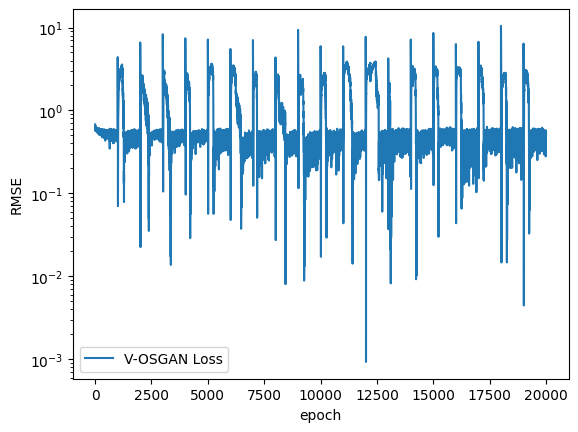

In [ ]:
plt.plot(all_loss)
#plt.plot(dis_loss_list)
#plt.plot(gen_loss_list)
plt.legend(['V-OSGAN Loss','Dis','gen'])
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.yscale('log')

# Preprocessing 2

**Preprocess synthetic data**

In [ ]:
gen_label = []
for i in range(num_of_classes):
    gen_label_temp = np.tile(i, data_to_gen)
    gen_label.extend(gen_label_temp)

gen_label = np.asarray(gen_label, dtype=np.float32)

In [ ]:
gen_data_reshaped = gen_data.reshape(num_of_classes*data_to_gen, data_shape[0])

X_train_gan, Y_train_gan = shuffle(gen_data_reshaped,
                                   gen_label,
                                   random_state=42)

In [ ]:
new_x_train = np.concatenate((X_train, X_train_gan), axis=0)
new_y_train = np.concatenate((Y_train, Y_train_gan), axis=0)

new_x_train, new_y_train = shuffle(new_x_train, new_y_train, random_state=42)
new_y_train_encoded = to_categorical(new_y_train)
new_x_train_transformed = scaler.fit_transform(new_x_train)

In [ ]:
# Split data into train, validation, and test sets
features_train, X_test_gan, labels_train, Y_test_gan = train_test_split(new_x_train_transformed, new_y_train, test_size=0.2, random_state= selection_seed)
features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=valid_split, random_state=42)

features_test = X_test_gan
labels_test = Y_test_gan
Y_test_gan_encoded = to_categorical(Y_test_gan)

# Convert to PyTorch tensors
features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.long)
features_val_tensor = torch.tensor(features_val, dtype=torch.float32)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.long)
features_test_tensor = torch.tensor(features_test, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.long)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(features_train_tensor, labels_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(features_val_tensor, labels_val_tensor), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(features_test_tensor, labels_test_tensor), batch_size=64, shuffle=False)

# Classification with MLP for Real + Synthetic Data

In [ ]:
# Simpan hasil
all_test_loss_gan =[]
gantest_accuracies_mlp = []
ganhistory = []

# Inisialisasi model terbaik
best_model_mlp_gan = None
best_acc_gan = 0

# Training loop
for i in range(times_to_run):
    seed(i * seed_multiplier)
    tf.random.set_seed(i * seed_multiplier)

    model = Sequential()
    model.add(Input(shape=(num_of_features,)))  # Define input shape explicitly
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_of_classes, activation='softmax'))

    model.compile(optimizer=Adam(lr_mlp, 0.5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    ganhistorytemp = model.fit(new_x_train_transformed,
                    new_y_train_encoded,
                    epochs=mlp_epochs,
                    batch_size=64,
                    validation_split=valid_split,
                    verbose = 0)
    ganhistory.append(ganhistorytemp)

    test_loss, test_acc = model.evaluate(X_test_gan,
                                         Y_test_gan_encoded,
                                         verbose=0)

    print(f"#{i} Test acc:", test_acc)
    gantest_accuracies_mlp.append(test_acc)
    all_test_loss_gan.append(test_loss)

    # Simpan model terbaik
    if test_acc > best_acc_gan:
        best_model_mlp_gan = model
        best_acc_gan = test_acc
    else:
        del model
        clear_session()

print("📊 Rata-rata akurasi:", np.mean(gantest_accuracies_mlp))
print("🎯 Akurasi terbaik:", best_acc_gan)

KeyboardInterrupt: 

In [ ]:
# Binarisasi label untuk ROC (one-hot)
y_pred_prob = best_model_mlp_gan.predict(X_test_transformed)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(Y_test_encoded, axis=1)
y_test_bin = label_binarize(y_true, classes=range(num_of_classes))  # shape: (n_samples, n_classes)

# ROC dan AUC per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung macro average AUC
macro_auc_m2 = np.mean(list(roc_auc.values()))

# Hitung micro average AUC (gabungkan semua prediksi)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
micro_auc_m2 = auc(fpr["micro"], tpr["micro"])

# 🌈 Plot ROC curve untuk beberapa kelas (maks 20)
plt.figure(figsize=(12, 8))
for i in range(min(20, num_of_classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'RP{i} (AUC = {roc_auc[i]:.2f})')

# Tambahkan micro ROC
plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--',
         label=f'Micro-average (AUC = {micro_auc_m2:.2f})')

micro_fpr_list_m2 = []
micro_tpr_list_m2 = []
micro_fpr_list_m2.append(fpr["micro"])
micro_tpr_list_m2.append(tpr["micro"])

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class + Micro Average")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Print summary
print(f"📊 Macro Average AUC: {macro_auc_m2:.4f}")
print(f"📊 Micro Average AUC: {micro_auc_m2:.4f}")

# Simpan hasil
filename = 'GANROC_MLP.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# RBFKAN Real + Fake Data

In [ ]:
# Store history untuk akurasi dan loss
gantrain_accuracies_rbfkan = []
ganval_accuracies_rbfkan = []
gantrain_losses_rbfkan = []
ganval_losses_rbfkan = []
gantest_accuracies_rbf = []

ganbest_model_rbfkan = None
ganbest_acc_rbfkan = 0

for i in range(num_iterations):
    print(f"🔁 Iterasi ke-{i+1}")
    torch.manual_seed(i * seed_multiplier)
    np.random.seed(i * seed_multiplier)

    # Inisialisasi model
    model = RBFKAN(
        layers_hidden=[input_dim] + hidden_layers + [output_dim],
        use_base_update=True,
        base_activation=nn.SiLU(),
        spline_weight_init_scale=0.1
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rbfkan)
    criterion = nn.CrossEntropyLoss()

    # Simpan akurasi & loss per epoch (untuk satu iterasi)
    train_acc_epochs = []
    val_acc_epochs = []
    train_loss_epochs = []
    val_loss_epochs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == batch_y).sum().item()
            total_train += batch_y.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_loss_epochs.append(avg_train_loss)
        train_acc_epochs.append(train_accuracy)

        # Validasi
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct_val += (preds == val_y).sum().item()
                total_val += val_y.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_loss_epochs.append(avg_val_loss)
        val_acc_epochs.append(val_accuracy)

    # Simpan per-epoch hasil iterasi ini
    gantrain_accuracies_rbfkan.append(train_acc_epochs)
    ganval_accuracies_rbfkan.append(val_acc_epochs)
    gantrain_losses_rbfkan.append(train_loss_epochs)
    ganval_losses_rbfkan.append(val_loss_epochs)

    # Evaluasi akhir di test set
    model.eval()
    with torch.no_grad():
        outputs = model(features_test_tensor)
        preds = torch.argmax(outputs, dim=1)
        test_acc = accuracy_score(labels_test_tensor.numpy(), preds.numpy())
        gantest_accuracies_rbf.append(test_acc)

    print(f"✅ Val acc (last epoch): {val_accuracy:.4f}, Test acc: {test_acc:.4f}")
    if test_acc > ganbest_acc_rbfkan:
        ganbest_model_rbfkan = model
        ganbest_acc_rbfkan = test_acc
    else:
        del model
        torch.cuda.empty_cache()

# Rata-rata per epoch dari semua iterasi
gantrain_accuracies_rbfkan = np.mean(gantrain_accuracies_rbfkan, axis=0)
ganval_accuracies_rbfkan = np.mean(ganval_accuracies_rbfkan, axis=0)
gantrain_losses_rbfkan = np.mean(gantrain_losses_rbfkan, axis=0)
ganval_losses_rbfkan = np.mean(ganval_losses_rbfkan, axis=0)

print("📊 Rata-rata akurasi uji RBFKAN:", np.mean(gantest_accuracies_rbf))
print("🎯 Akurasi terbaik RBFKAN:", ganbest_acc_rbfkan)

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os

# Pastikan model dalam mode evaluasi
ganbest_model_rbfkan.eval()

# Prediksi probabilitas (softmax)
with torch.no_grad():
    logits = ganbest_model_rbfkan(features_test_tensor)
    y_pred_prob = F.softmax(logits, dim=1).numpy()
    y_true = labels_test_tensor.numpy()

# Binarisasi label untuk ROC (one-hot)
y_test_bin = label_binarize(y_true, classes=range(num_of_classes))  # shape: (n_samples, n_classes)

# ROC dan AUC per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung macro average AUC
macro_auc_r2 = np.mean(list(roc_auc.values()))

# Hitung micro average AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
micro_auc_r2 = auc(fpr["micro"], tpr["micro"])

# 🌈 Plot ROC curve
plt.figure(figsize=(12, 8))
for i in range(min(20, num_of_classes)):  # Batasi maksimal 20 kelas
    plt.plot(fpr[i], tpr[i], lw=2, label=f'RP{i} (AUC = {roc_auc[i]:.2f})')

# Tambahkan micro average
plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--',
         label=f'Micro-average (AUC = {micro_auc_r2:.2f})')

micro_fpr_list_r2 = []
micro_tpr_list_r2 = []
micro_fpr_list_r2.append(fpr["micro"])
micro_tpr_list_r2.append(tpr["micro"])

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class + Micro Average (RBFKAN)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Print summary
print(f"📊 Macro Average AUC (RBFKAN): {macro_auc_r2:.4f}")
print(f"📊 Micro Average AUC (RBFKAN): {micro_auc_r2:.4f}")

# Simpan hasil
filename = 'GANROC_RBF.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# Result

In [ ]:
import matplotlib.pyplot as plt

# MLP metrics
gantrainacc = []
gantrainloss = []
ganvalacc = []
ganvalloss = []

for i in range(len(history)):
    gantrainacc.append(ganhistory[i].history['accuracy'])
    gantrainloss.append(ganhistory[i].history['loss'])
    ganvalacc.append(ganhistory[i].history['val_accuracy'])
    ganvalloss.append(ganhistory[i].history['val_loss'])

ganacc = np.mean(gantrainacc, axis=0)
ganval_acc = np.mean(ganvalacc, axis=0)
ganloss = np.mean(gantrainloss, axis=0)
ganval_loss = np.mean(ganvalloss, axis=0)
ganepochs = range(1, len(ganacc) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, ganacc, 'b>-', label='MLP Training Accuracy')
plt.plot(epochs, ganval_acc, 'b-', label='MLP Validation Accuracy')
plt.plot(epochs, gantrain_accuracies_rbfkan, 'ro--', label='RBFKAN Training Accuracy')
plt.plot(epochs, ganval_accuracies_rbfkan, 'r--', label='RBFKAN Validation Accuracy')
plt.title('Training and Validation Accuracy for {}% Data'.format(fraction_of_data*100))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

filename = 'GAN-Accuracy.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, ganloss, 'b>-', label='MLP Training Loss')
plt.plot(epochs, ganval_loss, 'b-', label='MLP Validation Loss')
plt.plot(epochs, gantrain_losses_rbfkan, 'ro--', label='RBFKAN Training Loss')
plt.plot(epochs, ganval_losses_rbfkan, 'r--', label='RBFKAN Validation Loss')
plt.title('Training and Validation Loss for {}% Data'.format(fraction_of_data*100))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

filename = 'GAN-Loss.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

In [ ]:
# Membaca dataset
file_path = dataset_file
data = pd.read_csv(file_path)

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values - 1  # Normalisasi label ke mulai dari 0

num_features = X.shape[1]
num_classes = len(np.unique(y))

combined_avg_rssi_per_class = []
delta = []

# Tentukan layout grid: misal 4 kolom per baris
n_cols = 5
n_rows = (num_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Flatten agar bisa diakses seperti list

for i in range(num_classes):
    class_data_gen = gen_data[i, :, :]
    class_data_csv = X[y == i, :]

    avg_rssi_per_feature_gen = class_data_gen.mean(axis=0)
    avg_rssi_per_feature_csv = class_data_csv.mean(axis=0)

    selisih = ((avg_rssi_per_feature_gen - avg_rssi_per_feature_csv)**2)**0.5
    delta.append(selisih)

    combined_avg_rssi = np.vstack((avg_rssi_per_feature_csv, avg_rssi_per_feature_gen)).T
    combined_avg_rssi_per_class.append(combined_avg_rssi)

    ax = axes[i]
    ax.plot(range(num_features), combined_avg_rssi[:, 0], marker='o', linestyle='-', alpha=0.7, label="Real Data")
    ax.plot(range(num_features), combined_avg_rssi[:, 1], marker='s', linestyle='-', alpha=0.7, label="Fake Data")
    ax.set_title(f'RP{i + 1}')
    ax.set_xlabel('Features')
    ax.set_ylabel('Avg RSSI')
    ax.set_xticks(range(num_features))
    ax.set_xticklabels([f'AP{j + 1}' for j in range(num_features)], rotation=45)
    ax.legend()
    ax.grid(True)

# Nonaktifkan subplot kosong jika jumlah kelas tidak genap
for j in range(num_classes, len(axes)):
    fig.delaxes(axes[j])

#fig.suptitle('📶 Average RSSI Value per Feature and Class', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("rssi_avg_per_class_grid.png", dpi=300)
#plt.show()

# Hitung delta rata-rata
def average(lst):
    return sum(lst) / len(lst)

print("Rata-rata delta per kelas:", average(delta))
print("Rata-rata keseluruhan:", average(average(delta)))

filename = 'Pattern.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

In [ ]:
# Standard deviation dari data real (X_train)
std_real = np.std(X_train, axis=0)

# Standard deviation dari data gabungan real + synthetic (new_x_train)
std_combined = np.std(new_x_train, axis=0)

print("📊 Standard Deviation per Fitur:")
for i in range(X_train.shape[1]):
    print(f"AP{i+1}: Real = {std_real[i]:.4f}, Real+Fake = {std_combined[i]:.4f}")

# Jika ingin mean dari seluruh std:
print("\n📈 Rata-rata STD (semua fitur):")
print(f"Real Only     : {np.mean(std_real):.4f}")
print(f"Real + Synthetic: {np.mean(std_combined):.4f}")

In [ ]:
num_features = X_train.shape[1]

# Buat 3x4 grid untuk 11 fitur
n_cols = 6
n_rows = (num_features + n_cols - 1) // n_cols  # hitung baris yang dibutuhkan

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows))
axes = axes.flatten()

for i in range(num_features):
    axes[i].hist(X_train[:, i], bins=30, alpha=0.5, label='Real', color='blue', density=True)
    axes[i].hist(new_x_train[:, i], bins=30, alpha=0.5, label='Real + Fake', color='orange', density=True)
    axes[i].set_title(f'AP{i+1}')
    axes[i].set_xlabel('RSSI (dBm)')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True)

# Matikan sisa subplot jika fitur tidak genap
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Simpan ke file
plt.savefig('persebaran_data_histogram.png', dpi=300)

filename = 'Deviation.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# Save Results

In [ ]:
AccMeanmlp = np.mean(test_accuracies_mlp)
AccStdmlp = np.std(test_accuracies_mlp)
AccMeanrbf = np.mean(test_accuracies_rbf)
AccStdrbf = np.std(test_accuracies_rbf)

GanAccMeanmlp = np.mean(gantest_accuracies_mlp)
GanAccStdmlp = np.std(gantest_accuracies_mlp)
GanAccMeanrbf = np.mean(gantest_accuracies_rbf)
GanAccStdrbf = np.std(gantest_accuracies_rbf)

deltaRSSI = average(delta)
deltaAll = average(average(delta))

lines  = list()
lines.append("Original Data (Each Class: {} Real):".format(num_of_data))
lines.append("Accuracy mean MLP: {}".format(AccMeanmlp))
lines.append("Accuracy STD MLP: {}".format(AccStdmlp))
lines.append("Accuracy mean RBFKAN: {}".format(AccMeanrbf))
lines.append("Accuracy STD RBFKAN: {}".format(AccStdrbf))
lines.append("Micro AUC MLP     : {}".format(micro_auc_m))
lines.append("Micro AUC RBFKAN     : {}".format(micro_auc_r))

lines.append("\n ================== \n")
lines.append("Original + GAN Data" +
             "(Each Class: {} Real + {} GAN):".format(num_of_data,
                                                      data_to_gen))
lines.append("Accuracy mean MLP: {}".format(GanAccMeanmlp))
lines.append("Accuracy STD MLP: {}".format(GanAccStdmlp))
lines.append("Accuracy mean RBFKAN: {}".format(GanAccMeanrbf))
lines.append("Accuracy STD RBFKAN: {}".format(GanAccStdrbf))
lines.append("Micro AUC MLP 2    : {}".format(micro_auc_m2))
lines.append("Micro AUC RBFKAN 2    : {}".format(micro_auc_r2))

lines.append("\n ================== \n")
lines.append("Average RSSI: {}".format(deltaRSSI))
lines.append("average difference All: {}".format(deltaAll))

lines.append("\n ================== \n")
lines.append("STD Real Only     : {}".format(np.mean(std_real)))
lines.append("STD Real + Synthetic: {}".format(np.mean(std_combined)))

lines.append("\n ================== \n")
lines.append("Macro AUC MLP     : {}".format(macro_auc_m))
lines.append("Macro AUC RBFKAN     : {}".format(macro_auc_r))
lines.append("Macro AUC MLP 2    : {}".format(macro_auc_m2))
lines.append("Macro AUC RBFKAN 2    : {}".format(macro_auc_r2))


file_dir = os.path.join(BASE_FOLDER, "result.txt")

with open(file_dir, "w") as filehandle:
    for items in lines:
        filehandle.write(f'{items}\n')

print(f"File berhasil disimpan di: {file_dir}")
